In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Clean stuff

In [2]:
!rm -rf /kaggle/working/*

# Import libraries and Customize Parameters

In [3]:
# Pip install method (recommended)
%pip install ultralytics
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 kB 21.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Importing the required libraries
from ultralytics import YOLO
import squarify
import matplotlib.pyplot as plt
import cv2
import os
import random
import pandas as pd
import matplotlib.image as mpimg
import seaborn as sns
import torch

sns.set_style('darkgrid')

%matplotlib inline

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
# Check if PyTorch is using the GPU
print("Is CUDA available? ", torch.cuda.is_available())
print("Device name: ", torch.cuda.get_device_name(0))
# Set the device to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device is on: {device}')

Is CUDA available?  True
Device name:  Tesla P100-PCIE-16GB
Device is on: cuda


# Visualize simple images with annotations

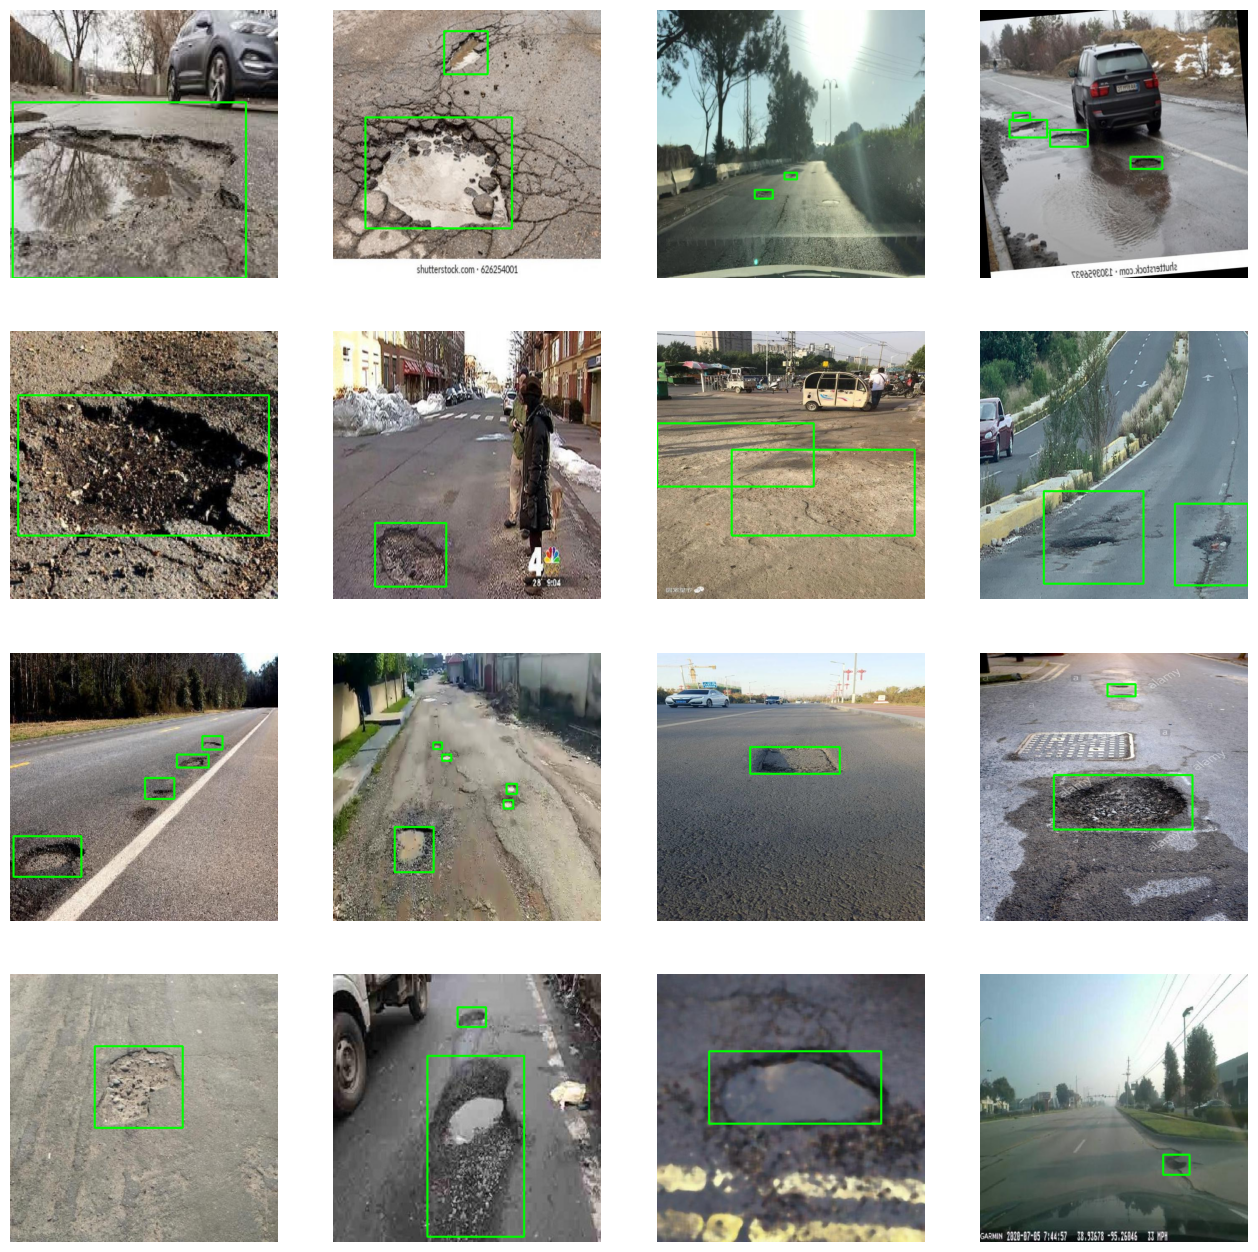

In [6]:
# Define the paths to the images and labels directories
train_images = "/kaggle/input/pothole-dataset/train/images"
train_labels = "/kaggle/input/pothole-dataset/train/labels"

test_images = "/kaggle/input/pothole-dataset/test/images"
test_labels = "/kaggle/input/pothole-dataset/test/images"

val_images = "/kaggle/input/pothole-dataset/valid/images"
val_labels = "/kaggle/input/pothole-dataset/valid/labels"

# Get a list of all the image files in the training images directory
image_files = os.listdir(train_images)

# Choose 16 random image files from the list
random_images = random.sample(image_files, 16)

# Set up the plot
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

# Loop over the random images and plot the object detections
for i, image_file in enumerate(random_images):
    row = i // 4
    col = i % 4
    
    # Load the image
    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)

    # Load the labels for this image
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(train_labels, label_file)
    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")

    # Loop over the labels and plot the object detections
    # Loop over the labels and plot the object detections
    for label in labels:
        if len(label.split()) != 5:
            continue
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width/2) * image.shape[1])
        y_min = int((y_center - height/2) * image.shape[0])
        x_max = int((x_center + width/2) * image.shape[1])
        y_max = int((y_center + height/2) * image.shape[0])
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)


    # Show the image with the object detections
    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

plt.show()

# Show image metadata

In [7]:
# Load an image using OpenCV
image = cv2.imread("/kaggle/input/pothole-dataset/test/images/0004_jpg.rf.f92ab952cd8544f887caf35fcccbcd10.jpg")

# Get the size of the image
height, width, channels = image.shape
print(f"The image has dimensions {width}x{height} and {channels} channels.")

The image has dimensions 640x640 and 3 channels.


# Model Training

In [8]:
# Loading a pretrained model
model = YOLO('yolo11s.pt')

# free up GPU memory
torch.cuda.empty_cache()

# Training the model
model.train(data = '/kaggle/input/pothole-dataset/data.yaml',
            epochs = 50,
            #patience = 10,
            imgsz = (height, width, channels)
            #seed = 42,
            #batch = 8,
            #workers = 4
           )

100%|██████████| 18.4M/18.4M [00:00<00:00, 221MB/s]


Ultralytics 8.3.35 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/kaggle/input/pothole-dataset/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=(640, 640, 3), save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tru

100%|██████████| 755k/755k [00:00<00:00, 23.9MB/s]
2024-11-21 17:17:36,135	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-11-21 17:17:36,598	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 102MB/s]


AMP: checks passed ✅
WARNING ⚠️ updating to 'imgsz=640'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'


train: Scanning /kaggle/input/pothole-dataset/train/labels... 11068 images, 0 backgrounds, 0 corrupt: 100%|██████████| 11068/11068 [00:35<00:00, 312.86it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/pothole-dataset/train is not writeable, cache not saved.
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 3815, len(boxes) = 29161. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/pothole-dataset/valid/labels... 1808 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1808/1808 [00:04<00:00, 368.47it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/pothole-dataset/valid is not writeable, cache not saved.
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.72G      1.808      2.144      1.689         26        640: 100%|██████████| 692/692 [03:53<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:15<00:00,  3.60it/s]


                   all       1808       4487      0.378       0.35      0.298      0.122

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.87G      1.835      1.847      1.718         35        640: 100%|██████████| 692/692 [03:47<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.89it/s]


                   all       1808       4487      0.524      0.404      0.409      0.174

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.79G       1.79      1.765      1.677         59        640: 100%|██████████| 692/692 [03:45<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.88it/s]


                   all       1808       4487      0.545      0.454      0.453      0.197

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       4.9G      1.753      1.699      1.645         38        640: 100%|██████████| 692/692 [03:44<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.90it/s]


                   all       1808       4487      0.645      0.475      0.531       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.82G      1.695      1.601      1.617         24        640: 100%|██████████| 692/692 [03:44<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.82it/s]


                   all       1808       4487      0.641      0.508      0.554      0.256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.89G      1.666      1.549      1.585         69        640: 100%|██████████| 692/692 [03:44<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.86it/s]


                   all       1808       4487      0.653      0.542      0.583      0.275

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.81G      1.643      1.507      1.572         68        640: 100%|██████████| 692/692 [03:44<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.91it/s]


                   all       1808       4487      0.683      0.555      0.614      0.296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.81G      1.626      1.481      1.554        109        640: 100%|██████████| 692/692 [03:44<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.89it/s]


                   all       1808       4487      0.696      0.564      0.628      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.91G      1.592      1.435      1.534         55        640: 100%|██████████| 692/692 [03:44<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.89it/s]


                   all       1808       4487      0.689       0.56      0.619      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.91G      1.587      1.424      1.525         68        640: 100%|██████████| 692/692 [03:44<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.85it/s]


                   all       1808       4487      0.699      0.582      0.649      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.81G      1.571       1.38      1.511         62        640: 100%|██████████| 692/692 [03:44<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.94it/s]


                   all       1808       4487      0.687       0.58      0.637      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50       4.8G      1.548      1.352      1.495         45        640: 100%|██████████| 692/692 [03:44<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.88it/s]


                   all       1808       4487      0.697      0.582       0.65       0.33

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.83G      1.542      1.343      1.492         45        640: 100%|██████████| 692/692 [03:44<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.87it/s]


                   all       1808       4487      0.733      0.589      0.663      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.81G      1.529      1.317      1.489         49        640: 100%|██████████| 692/692 [03:44<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.87it/s]


                   all       1808       4487      0.716      0.606       0.67      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.91G      1.514      1.297      1.472         95        640: 100%|██████████| 692/692 [03:44<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.88it/s]


                   all       1808       4487      0.713       0.61      0.675      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.81G      1.492      1.274      1.452         43        640: 100%|██████████| 692/692 [03:44<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.91it/s]


                   all       1808       4487      0.731      0.611      0.682      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.81G      1.487       1.26      1.447         45        640: 100%|██████████| 692/692 [03:44<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.89it/s]


                   all       1808       4487      0.748      0.616      0.699      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.81G      1.481      1.249      1.448         93        640: 100%|██████████| 692/692 [03:44<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.95it/s]


                   all       1808       4487      0.723      0.622       0.69      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.81G      1.478      1.245      1.447         33        640: 100%|██████████| 692/692 [03:44<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.89it/s]


                   all       1808       4487      0.725      0.648      0.705      0.383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.81G       1.45      1.214      1.432         59        640: 100%|██████████| 692/692 [03:44<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.89it/s]


                   all       1808       4487      0.749      0.657      0.725        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.86G      1.441      1.189      1.422         51        640: 100%|██████████| 692/692 [03:44<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.94it/s]


                   all       1808       4487       0.74      0.658      0.724      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       4.8G      1.431      1.186      1.421         44        640: 100%|██████████| 692/692 [03:44<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.90it/s]


                   all       1808       4487      0.751      0.655      0.732      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       4.8G      1.417      1.156      1.405         48        640: 100%|██████████| 692/692 [03:44<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.94it/s]


                   all       1808       4487      0.756      0.684      0.742       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.89G      1.415      1.149      1.399         51        640: 100%|██████████| 692/692 [03:44<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.92it/s]


                   all       1808       4487      0.775      0.678       0.75      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.86G      1.403      1.143      1.396         44        640: 100%|██████████| 692/692 [03:44<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.98it/s]


                   all       1808       4487      0.764      0.679       0.75      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.81G       1.39      1.122       1.39         36        640: 100%|██████████| 692/692 [03:44<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.88it/s]


                   all       1808       4487      0.787       0.68      0.761      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.81G      1.383      1.117      1.386         58        640: 100%|██████████| 692/692 [03:44<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.97it/s]


                   all       1808       4487      0.774      0.687      0.761      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       4.8G      1.368      1.096      1.368         28        640: 100%|██████████| 692/692 [03:44<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.90it/s]


                   all       1808       4487      0.788       0.69      0.773      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       4.8G      1.363      1.089      1.364         57        640: 100%|██████████| 692/692 [03:44<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.87it/s]


                   all       1808       4487      0.796      0.682      0.774      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       4.8G      1.346      1.063      1.354         60        640: 100%|██████████| 692/692 [03:44<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.87it/s]


                   all       1808       4487      0.798      0.702       0.78      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.91G      1.349      1.059      1.356         48        640: 100%|██████████| 692/692 [03:44<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.91it/s]


                   all       1808       4487      0.799      0.703      0.783      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.82G      1.332      1.043      1.344         40        640: 100%|██████████| 692/692 [03:44<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.90it/s]


                   all       1808       4487      0.827      0.697      0.789      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       4.8G       1.32      1.026      1.327         71        640: 100%|██████████| 692/692 [03:44<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.92it/s]


                   all       1808       4487      0.823        0.7      0.788      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.81G      1.316      1.014      1.333         43        640: 100%|██████████| 692/692 [03:44<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.97it/s]


                   all       1808       4487      0.825      0.709      0.799      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       4.8G        1.3      0.997      1.321         52        640: 100%|██████████| 692/692 [03:44<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.89it/s]

                   all       1808       4487      0.832      0.711      0.798      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.88G       1.29     0.9849      1.312         38        640: 100%|██████████| 692/692 [03:44<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.94it/s]


                   all       1808       4487      0.824      0.715      0.803      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.89G      1.281     0.9765       1.31         57        640: 100%|██████████| 692/692 [03:44<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.91it/s]


                   all       1808       4487      0.819      0.731      0.804      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.89G      1.268     0.9626      1.303         60        640: 100%|██████████| 692/692 [03:44<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.86it/s]

                   all       1808       4487       0.84      0.718      0.808      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       4.9G      1.257     0.9455      1.294         24        640: 100%|██████████| 692/692 [03:44<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.91it/s]


                   all       1808       4487       0.83       0.73      0.811      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.88G      1.256     0.9493      1.291         42        640: 100%|██████████| 692/692 [03:44<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.92it/s]

                   all       1808       4487      0.835      0.734      0.816        0.5


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       4.8G      1.223     0.8454      1.274         26        640: 100%|██████████| 692/692 [03:44<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.93it/s]

                   all       1808       4487      0.821      0.742      0.813      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.74G      1.195     0.8098      1.256         21        640: 100%|██████████| 692/692 [03:44<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.87it/s]

                   all       1808       4487      0.833      0.749      0.822      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.86G      1.184      0.799       1.25         33        640: 100%|██████████| 692/692 [03:44<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.93it/s]

                   all       1808       4487      0.832      0.746      0.821      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.86G      1.169     0.7784      1.243         31        640: 100%|██████████| 692/692 [03:44<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.82it/s]

                   all       1808       4487      0.839      0.749      0.824      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       4.5G      1.159     0.7719      1.231         22        640: 100%|██████████| 692/692 [03:44<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.91it/s]

                   all       1808       4487      0.837      0.756      0.827      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.87G      1.141     0.7511      1.223         37        640: 100%|██████████| 692/692 [03:44<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.92it/s]

                   all       1808       4487      0.851      0.746      0.827      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.91G      1.131     0.7421      1.215         34        640: 100%|██████████| 692/692 [03:44<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.96it/s]


                   all       1808       4487      0.844      0.753      0.828      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.74G      1.124      0.732      1.207         42        640: 100%|██████████| 692/692 [03:44<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.93it/s]

                   all       1808       4487      0.841      0.761      0.831      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       4.5G      1.112     0.7234      1.204         30        640: 100%|██████████| 692/692 [03:44<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.99it/s]

                   all       1808       4487      0.843      0.762      0.834      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.75G      1.099      0.717      1.197         21        640: 100%|██████████| 692/692 [03:44<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.95it/s]

                   all       1808       4487      0.849      0.762      0.834      0.538



50 epochs completed in 3.341 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 19.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 19.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.35 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:15<00:00,  3.62it/s]


                   all       1808       4487       0.85      0.761      0.834      0.538
Speed: 0.2ms preprocess, 4.7ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f5a90a19ed0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Model Performance

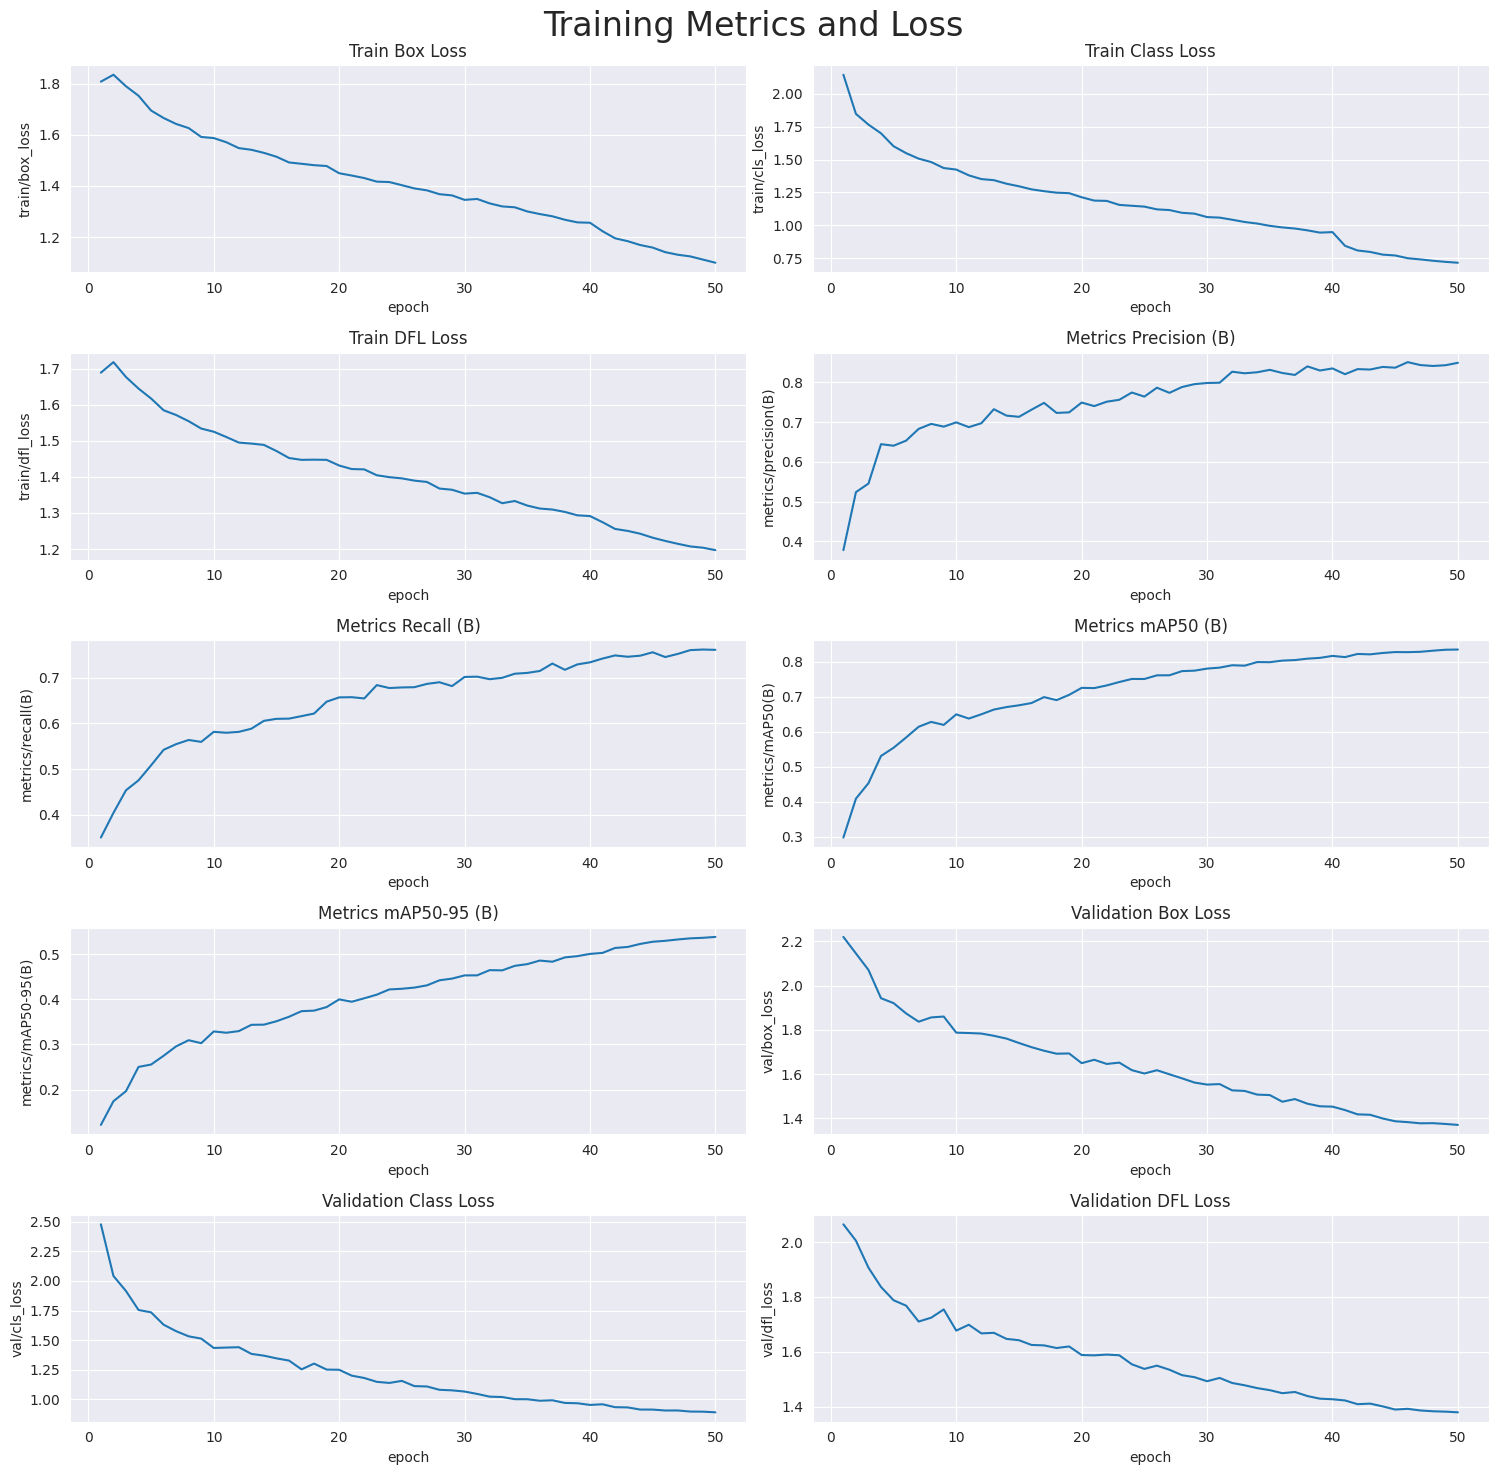

In [9]:
%matplotlib inline
# read in the results.csv file as a pandas dataframe
df = pd.read_csv('/kaggle/working/runs/detect/train/results.csv')
df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()

# Model Evaluation

In [10]:
%matplotlib inline
# Loading the best performing model
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

# Evaluating the model on the test dataset
metrics = model.val(conf = 0.25, split = 'test')

Ultralytics 8.3.35 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning /kaggle/input/pothole-dataset/test/labels... 891 images, 0 backgrounds, 0 corrupt: 100%|██████████| 891/891 [00:03<00:00, 245.00it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/pothole-dataset/test is not writeable, cache not saved.
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 8, len(boxes) = 2171. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:08<00:00,  6.30it/s]


                   all        891       2171      0.843      0.777      0.843      0.583
Speed: 0.2ms preprocess, 5.3ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/val


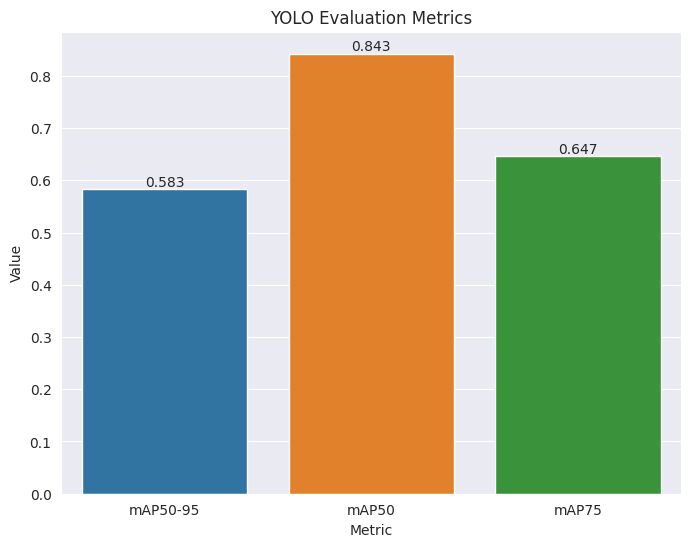

In [11]:
%matplotlib inline
# Create the barplot
ax = sns.barplot(x=['mAP50-95', 'mAP50', 'mAP75'], y=[metrics.box.map, metrics.box.map50, metrics.box.map75])

# Set the title and axis labels
ax.set_title('YOLO Evaluation Metrics')
ax.set_xlabel('Metric')
ax.set_ylabel('Value')

# Set the figure size
fig = plt.gcf()
fig.set_size_inches(8, 6)

# Add the values on top of the bars
for p in ax.patches:
    ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
    
# Show the plot
plt.show()


## Confusion Matrix

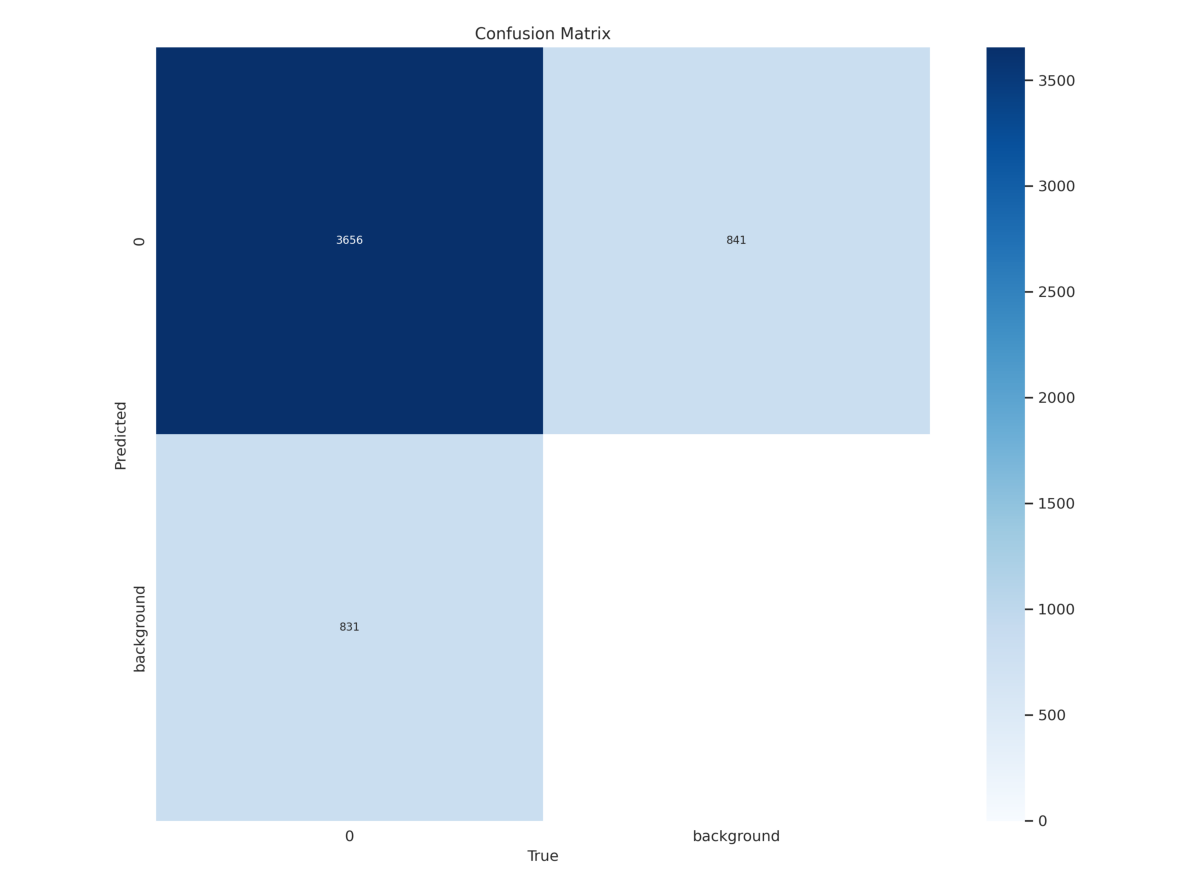

In [12]:
%matplotlib inline
# Reading the confusion matrix image file
img = mpimg.imread('/kaggle/working/runs/detect/train/confusion_matrix.png')

# Plotting the confusion matrix image
fig, ax = plt.subplots(figsize = (15, 15))

ax.imshow(img)
ax.axis('off');

# Making Predictions on Test Images

In [13]:
# Function to perform ship detections
def pothole_detect(img_path):
    
    # Read the image
    img = cv2.imread(img_path)

    # Pass the image through the detection model and get the result
    detect_result = model(img)

    # Plot the detections
    detect_img = detect_result[0].plot()
    
    # Convert the image to RGB format
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)
    
    return detect_img


0: 640x640 3 0s, 9.2ms
Speed: 1.8ms preprocess, 9.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 0, 9.2ms
Speed: 2.6ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 9.1ms
Speed: 2.1ms preprocess, 9.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 0s, 9.2ms
Speed: 1.9ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 0, 9.1ms
Speed: 2.4ms preprocess, 9.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 0, 9.1ms
Speed: 2.2ms preprocess, 9.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 0, 9.2ms
Speed: 3.2ms preprocess, 9.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 0s, 9.2ms
Speed: 2.1ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 0, 9.1ms
Speed: 1.7

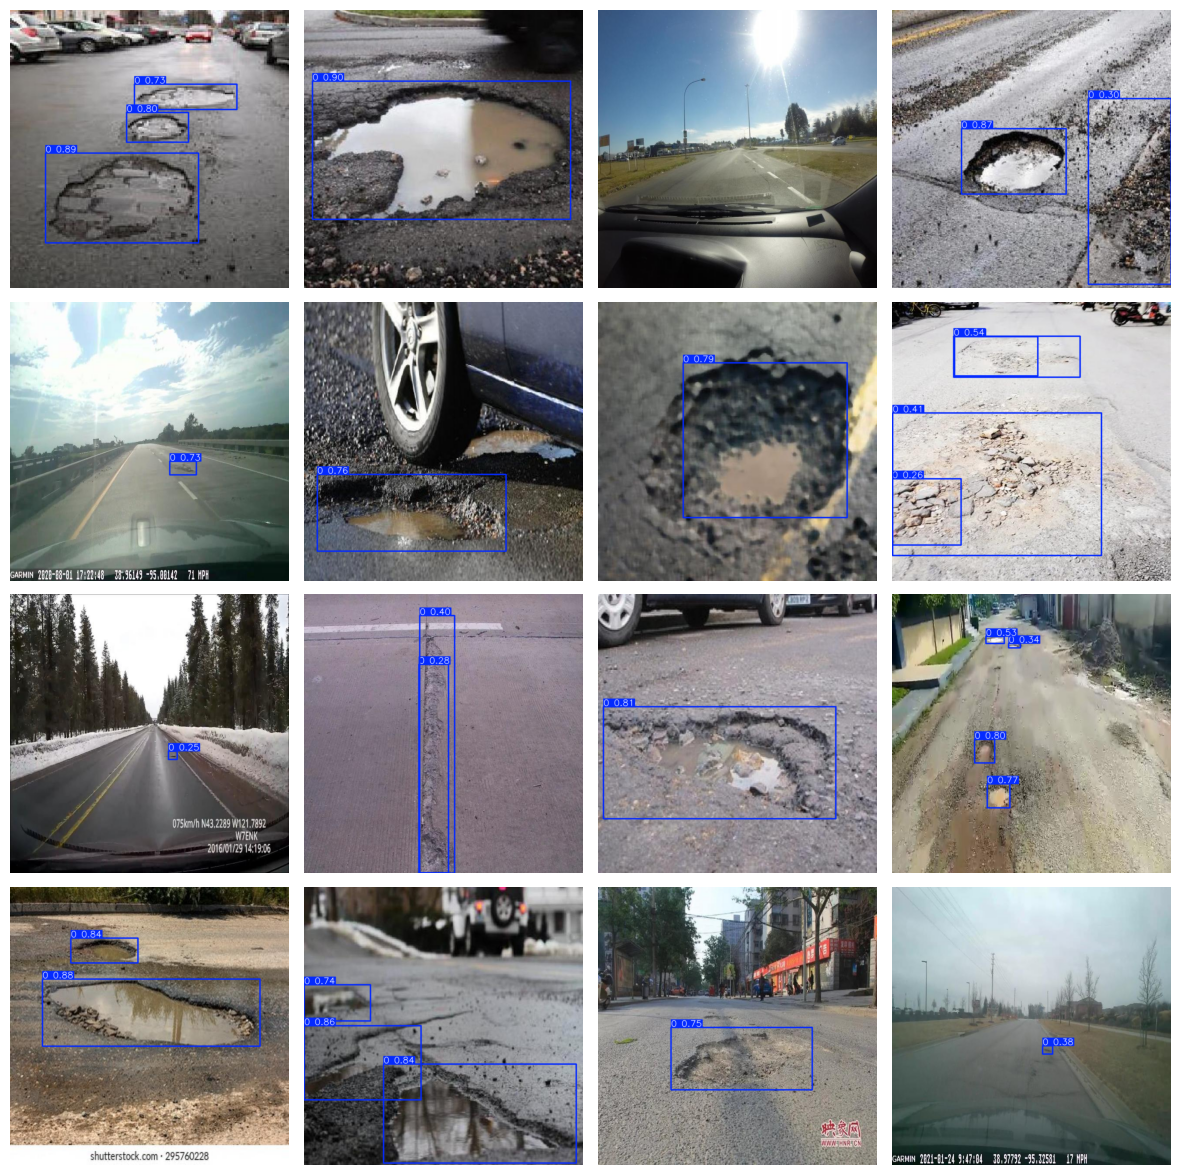

In [14]:
import random

# Define the directory where the custom images are stored
custom_image_dir = '/kaggle/input/pothole-dataset/test/images'

# Get the list of image files in the directory
image_files = os.listdir(custom_image_dir)

# Select 16 random images from the list
selected_images = random.sample(image_files, 16)

# Create a figure with subplots for each image
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

# Iterate over the selected images and plot each one
for i, img_file in enumerate(selected_images):
    
    # Compute the row and column index of the current subplot
    row_idx = i // 4
    col_idx = i % 4
    
    # Load the current image and run object detection
    img_path = os.path.join(custom_image_dir, img_file)
    detect_img = pothole_detect(img_path)
    
    # Plot the current image on the appropriate subplot
    axes[row_idx, col_idx].imshow(detect_img)
    axes[row_idx, col_idx].axis('off')

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# Export model

In [15]:
    # Save model
    torch.save(model, "pothole_model.pt")

    # Export model 
    model.export(format="onnx")

    # Export model
    model.export(format="engine")

TypeError: cannot pickle '_thread.lock' object

# Download train results and model

In [ ]:
# zip the test results folder
!zip -r yolo_training_results.zip /kaggle/working/runs

In [ ]:
!mkdir /kaggle/output/
!mv yolo_training_results.zip /kaggle/output/